# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM_CNN_AE/LSTM3_CNN_slide_augumentation/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'],
                aug_window_size=config['fit']['aug_window_size'],
                aug_hop_size=config['fit']['aug_hop_size']
                )
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-08 18:10:57,963 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-08 18:10:57,964 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 18:10:58,791 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:36<00:00, 49.86it/s]


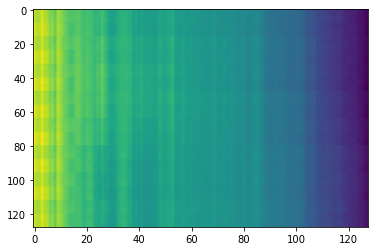

2020-11-08 18:15:46,536 - pytorch_modeler.py - INFO - Epoch 1/55:train_loss:829.625627, valid_AUC:0.521709, valid_pAUC:0.504652
100%|██████████| 1803/1803 [00:34<00:00, 52.24it/s]
2020-11-08 18:20:29,879 - pytorch_modeler.py - INFO - Epoch 2/55:train_loss:607.157571, valid_AUC:0.527402, valid_pAUC:0.503254
100%|██████████| 1803/1803 [00:37<00:00, 48.63it/s]
2020-11-08 18:25:16,440 - pytorch_modeler.py - INFO - Epoch 3/55:train_loss:441.269479, valid_AUC:0.500015, valid_pAUC:0.505402
100%|██████████| 1803/1803 [00:33<00:00, 53.37it/s]
2020-11-08 18:30:01,259 - pytorch_modeler.py - INFO - Epoch 4/55:train_loss:313.823706, valid_AUC:0.499993, valid_pAUC:0.509707
100%|██████████| 1803/1803 [00:37<00:00, 47.50it/s]
2020-11-08 18:34:49,100 - pytorch_modeler.py - INFO - Epoch 5/55:train_loss:216.169051, valid_AUC:0.493372, valid_pAUC:0.513261
100%|██████████| 1803/1803 [00:35<00:00, 50.09it/s]
2020-11-08 18:39:39,213 - pytorch_modeler.py - INFO - Epoch 6/55:train_loss:143.399875, valid_AUC:0.

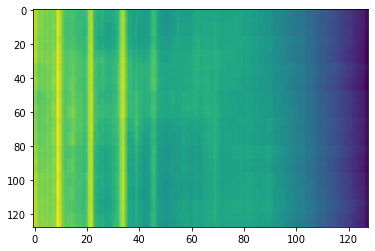

2020-11-08 18:58:57,390 - pytorch_modeler.py - INFO - Epoch 10/55:train_loss:20.744797, valid_AUC:0.552286, valid_pAUC:0.511329
100%|██████████| 1803/1803 [00:36<00:00, 49.90it/s]
2020-11-08 19:03:40,510 - pytorch_modeler.py - INFO - Epoch 11/55:train_loss:14.366727, valid_AUC:0.594481, valid_pAUC:0.509660
100%|██████████| 1803/1803 [00:35<00:00, 50.60it/s]
2020-11-08 19:08:20,560 - pytorch_modeler.py - INFO - Epoch 12/55:train_loss:11.434588, valid_AUC:0.576605, valid_pAUC:0.510082
100%|██████████| 1803/1803 [00:39<00:00, 46.10it/s]
2020-11-08 19:13:06,954 - pytorch_modeler.py - INFO - Epoch 13/55:train_loss:10.479319, valid_AUC:0.601905, valid_pAUC:0.514030
100%|██████████| 1803/1803 [00:35<00:00, 50.49it/s]
2020-11-08 19:17:50,135 - pytorch_modeler.py - INFO - Epoch 14/55:train_loss:10.201300, valid_AUC:0.617133, valid_pAUC:0.510832
100%|██████████| 1803/1803 [00:37<00:00, 48.60it/s]
2020-11-08 19:22:33,381 - pytorch_modeler.py - INFO - Epoch 15/55:train_loss:10.022525, valid_AUC:0.

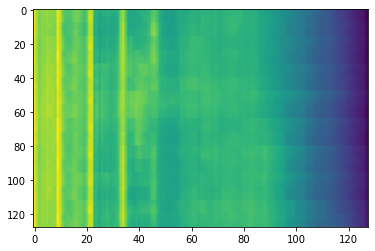

2020-11-08 19:46:23,910 - pytorch_modeler.py - INFO - Epoch 20/55:train_loss:9.887526, valid_AUC:0.589122, valid_pAUC:0.512905
100%|██████████| 1803/1803 [00:36<00:00, 49.42it/s]
2020-11-08 19:51:06,036 - pytorch_modeler.py - INFO - Epoch 21/55:train_loss:9.902116, valid_AUC:0.628680, valid_pAUC:0.516309
100%|██████████| 1803/1803 [00:42<00:00, 42.38it/s]
2020-11-08 19:55:59,867 - pytorch_modeler.py - INFO - Epoch 22/55:train_loss:9.792640, valid_AUC:0.620328, valid_pAUC:0.518738
100%|██████████| 1803/1803 [00:38<00:00, 47.33it/s]
2020-11-08 20:00:51,761 - pytorch_modeler.py - INFO - Epoch 23/55:train_loss:9.731554, valid_AUC:0.616989, valid_pAUC:0.513767
100%|██████████| 1803/1803 [00:39<00:00, 46.11it/s]
2020-11-08 20:05:40,925 - pytorch_modeler.py - INFO - Epoch 24/55:train_loss:9.679629, valid_AUC:0.629469, valid_pAUC:0.515709
100%|██████████| 1803/1803 [00:39<00:00, 45.97it/s]
2020-11-08 20:10:35,371 - pytorch_modeler.py - INFO - Epoch 25/55:train_loss:9.652805, valid_AUC:0.630112

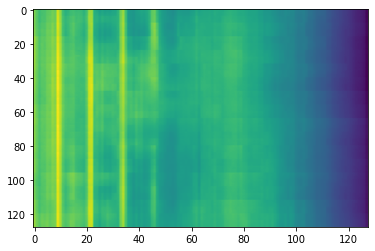

2020-11-08 20:35:12,551 - pytorch_modeler.py - INFO - Epoch 30/55:train_loss:9.798283, valid_AUC:0.610527, valid_pAUC:0.511198
100%|██████████| 1803/1803 [00:38<00:00, 46.40it/s]
2020-11-08 20:40:04,818 - pytorch_modeler.py - INFO - Epoch 31/55:train_loss:9.694126, valid_AUC:0.616814, valid_pAUC:0.517988
100%|██████████| 1803/1803 [00:38<00:00, 46.49it/s]
2020-11-08 20:44:56,456 - pytorch_modeler.py - INFO - Epoch 32/55:train_loss:9.554660, valid_AUC:0.631712, valid_pAUC:0.518429
100%|██████████| 1803/1803 [01:01<00:00, 29.55it/s]
2020-11-08 20:50:20,506 - pytorch_modeler.py - INFO - Epoch 33/55:train_loss:9.522607, valid_AUC:0.624884, valid_pAUC:0.513786
100%|██████████| 1803/1803 [00:46<00:00, 38.43it/s]
2020-11-08 20:56:05,074 - pytorch_modeler.py - INFO - Epoch 34/55:train_loss:9.515447, valid_AUC:0.618773, valid_pAUC:0.515756
100%|██████████| 1803/1803 [01:03<00:00, 28.61it/s]
2020-11-08 21:02:08,843 - pytorch_modeler.py - INFO - Epoch 35/55:train_loss:9.523759, valid_AUC:0.630273

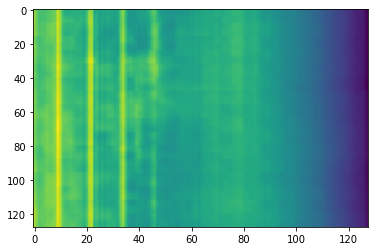

2020-11-08 21:35:21,248 - pytorch_modeler.py - INFO - Epoch 40/55:train_loss:9.389026, valid_AUC:0.628177, valid_pAUC:0.514959
100%|██████████| 1803/1803 [00:37<00:00, 47.54it/s]
2020-11-08 21:40:08,396 - pytorch_modeler.py - INFO - Epoch 41/55:train_loss:9.370812, valid_AUC:0.627015, valid_pAUC:0.511432
100%|██████████| 1803/1803 [00:36<00:00, 49.44it/s]
2020-11-08 21:44:55,050 - pytorch_modeler.py - INFO - Epoch 42/55:train_loss:9.389933, valid_AUC:0.635907, valid_pAUC:0.514565
100%|██████████| 1803/1803 [00:38<00:00, 46.69it/s]
2020-11-08 21:49:41,370 - pytorch_modeler.py - INFO - Epoch 43/55:train_loss:9.343052, valid_AUC:0.635028, valid_pAUC:0.514499
100%|██████████| 1803/1803 [00:37<00:00, 47.69it/s]
2020-11-08 21:54:27,104 - pytorch_modeler.py - INFO - Epoch 44/55:train_loss:9.313587, valid_AUC:0.630766, valid_pAUC:0.516356
100%|██████████| 1803/1803 [00:39<00:00, 45.55it/s]
2020-11-08 21:59:19,736 - pytorch_modeler.py - INFO - Epoch 45/55:train_loss:9.333296, valid_AUC:0.628632

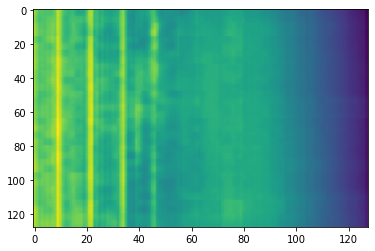

2020-11-08 22:23:33,307 - pytorch_modeler.py - INFO - Epoch 50/55:train_loss:9.237478, valid_AUC:0.618713, valid_pAUC:0.510373
100%|██████████| 1803/1803 [00:40<00:00, 45.02it/s]
2020-11-08 22:28:24,967 - pytorch_modeler.py - INFO - Epoch 51/55:train_loss:9.223365, valid_AUC:0.633867, valid_pAUC:0.517022
100%|██████████| 1803/1803 [00:39<00:00, 45.92it/s]
2020-11-08 22:33:15,360 - pytorch_modeler.py - INFO - Epoch 52/55:train_loss:9.234179, valid_AUC:0.641579, valid_pAUC:0.519320
100%|██████████| 1803/1803 [00:39<00:00, 45.70it/s]
2020-11-08 22:38:05,460 - pytorch_modeler.py - INFO - Epoch 53/55:train_loss:9.238461, valid_AUC:0.632215, valid_pAUC:0.511423
100%|██████████| 1803/1803 [00:38<00:00, 47.05it/s]
2020-11-08 22:42:53,348 - pytorch_modeler.py - INFO - Epoch 54/55:train_loss:9.230925, valid_AUC:0.633035, valid_pAUC:0.515568
100%|██████████| 1803/1803 [00:39<00:00, 45.87it/s]
2020-11-08 22:47:43,652 - pytorch_modeler.py - INFO - Epoch 55/55:train_loss:9.210285, valid_AUC:0.635214

elapsed time: 16605.907066584 [sec]


2020-11-08 22:47:44,483 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-08 22:47:44,484 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 22:47:44,493 - 00_train.py - INFO - TRAINING
  0%|          | 0/361 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:23<00:00, 35.17it/s]


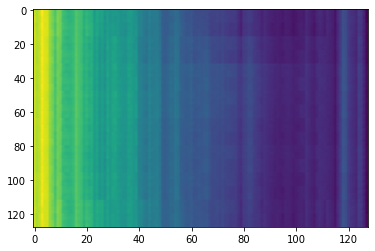

2020-11-08 22:52:43,391 - pytorch_modeler.py - INFO - Epoch 1/55:train_loss:845.708069, valid_AUC:0.288067, valid_pAUC:0.488030
100%|██████████| 832/832 [00:16<00:00, 49.01it/s]
2020-11-08 22:56:43,937 - pytorch_modeler.py - INFO - Epoch 2/55:train_loss:642.437908, valid_AUC:0.289821, valid_pAUC:0.489279
100%|██████████| 832/832 [00:16<00:00, 49.12it/s]
2020-11-08 23:00:43,124 - pytorch_modeler.py - INFO - Epoch 3/55:train_loss:487.094814, valid_AUC:0.329036, valid_pAUC:0.483035
100%|██████████| 832/832 [00:18<00:00, 45.75it/s]
2020-11-08 23:04:42,910 - pytorch_modeler.py - INFO - Epoch 4/55:train_loss:363.993927, valid_AUC:0.287396, valid_pAUC:0.489096
100%|██████████| 832/832 [00:17<00:00, 47.65it/s]
2020-11-08 23:08:42,959 - pytorch_modeler.py - INFO - Epoch 5/55:train_loss:266.006097, valid_AUC:0.382367, valid_pAUC:0.488822
100%|██████████| 832/832 [00:18<00:00, 45.09it/s]
2020-11-08 23:12:42,906 - pytorch_modeler.py - INFO - Epoch 6/55:train_loss:188.834931, valid_AUC:0.303594, va

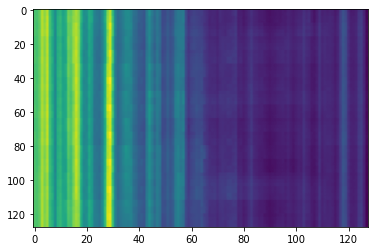

2020-11-08 23:28:43,566 - pytorch_modeler.py - INFO - Epoch 10/55:train_loss:36.192453, valid_AUC:0.650301, valid_pAUC:0.556287
100%|██████████| 832/832 [00:17<00:00, 48.51it/s]
2020-11-08 23:32:43,443 - pytorch_modeler.py - INFO - Epoch 11/55:train_loss:23.469191, valid_AUC:0.698056, valid_pAUC:0.557657
100%|██████████| 832/832 [00:17<00:00, 47.29it/s]
2020-11-08 23:36:42,737 - pytorch_modeler.py - INFO - Epoch 12/55:train_loss:16.315832, valid_AUC:0.657159, valid_pAUC:0.523544
100%|██████████| 832/832 [00:18<00:00, 45.76it/s]
2020-11-08 23:40:45,676 - pytorch_modeler.py - INFO - Epoch 13/55:train_loss:12.743500, valid_AUC:0.706282, valid_pAUC:0.561373
100%|██████████| 832/832 [00:18<00:00, 45.34it/s]
2020-11-08 23:44:46,960 - pytorch_modeler.py - INFO - Epoch 14/55:train_loss:11.150973, valid_AUC:0.706933, valid_pAUC:0.581049
100%|██████████| 832/832 [00:17<00:00, 46.89it/s]
2020-11-08 23:48:47,016 - pytorch_modeler.py - INFO - Epoch 15/55:train_loss:10.644977, valid_AUC:0.703955, va

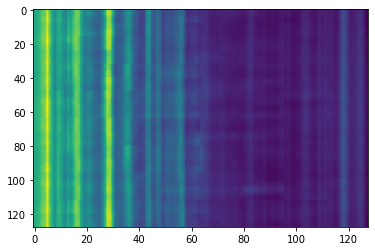

2020-11-09 00:08:57,778 - pytorch_modeler.py - INFO - Epoch 20/55:train_loss:9.989784, valid_AUC:0.727106, valid_pAUC:0.576298
100%|██████████| 832/832 [00:18<00:00, 46.09it/s]
2020-11-09 00:12:58,343 - pytorch_modeler.py - INFO - Epoch 21/55:train_loss:10.025973, valid_AUC:0.714763, valid_pAUC:0.548977
100%|██████████| 832/832 [00:19<00:00, 43.64it/s]
2020-11-09 00:16:59,349 - pytorch_modeler.py - INFO - Epoch 22/55:train_loss:9.887954, valid_AUC:0.716591, valid_pAUC:0.564388
100%|██████████| 832/832 [00:18<00:00, 44.42it/s]
2020-11-09 00:21:01,922 - pytorch_modeler.py - INFO - Epoch 23/55:train_loss:9.879952, valid_AUC:0.716447, valid_pAUC:0.574348
100%|██████████| 832/832 [00:18<00:00, 45.60it/s]
2020-11-09 00:25:01,123 - pytorch_modeler.py - INFO - Epoch 24/55:train_loss:9.844800, valid_AUC:0.718640, valid_pAUC:0.573922
100%|██████████| 832/832 [00:18<00:00, 45.19it/s]
2020-11-09 00:28:59,080 - pytorch_modeler.py - INFO - Epoch 25/55:train_loss:9.718622, valid_AUC:0.707280, valid_p

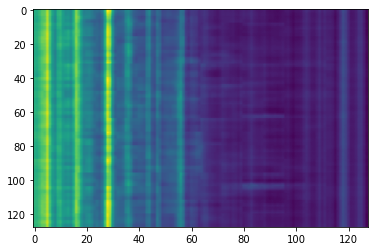

2020-11-09 00:49:18,970 - pytorch_modeler.py - INFO - Epoch 30/55:train_loss:9.376603, valid_AUC:0.731603, valid_pAUC:0.592044
100%|██████████| 832/832 [00:18<00:00, 44.63it/s]
2020-11-09 00:53:34,544 - pytorch_modeler.py - INFO - Epoch 31/55:train_loss:9.345798, valid_AUC:0.720961, valid_pAUC:0.581506
100%|██████████| 832/832 [00:17<00:00, 46.65it/s]
2020-11-09 00:57:42,901 - pytorch_modeler.py - INFO - Epoch 32/55:train_loss:9.344777, valid_AUC:0.735909, valid_pAUC:0.607060
100%|██████████| 832/832 [00:19<00:00, 42.97it/s]
2020-11-09 01:01:45,045 - pytorch_modeler.py - INFO - Epoch 33/55:train_loss:9.290969, valid_AUC:0.732187, valid_pAUC:0.585526
100%|██████████| 832/832 [00:18<00:00, 45.03it/s]
2020-11-09 01:05:50,346 - pytorch_modeler.py - INFO - Epoch 34/55:train_loss:9.402589, valid_AUC:0.725446, valid_pAUC:0.584613
100%|██████████| 832/832 [00:19<00:00, 42.18it/s]
2020-11-09 01:09:57,012 - pytorch_modeler.py - INFO - Epoch 35/55:train_loss:9.386985, valid_AUC:0.733218, valid_pA

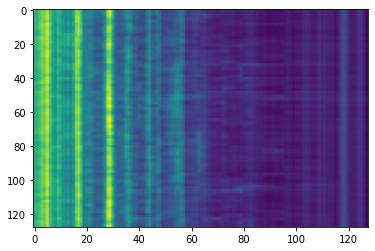

2020-11-09 01:30:28,596 - pytorch_modeler.py - INFO - Epoch 40/55:train_loss:9.019680, valid_AUC:0.743872, valid_pAUC:0.586135
100%|██████████| 832/832 [00:16<00:00, 50.51it/s]
2020-11-09 01:34:34,257 - pytorch_modeler.py - INFO - Epoch 41/55:train_loss:9.028296, valid_AUC:0.743993, valid_pAUC:0.598197
100%|██████████| 832/832 [00:16<00:00, 50.40it/s]
2020-11-09 01:38:28,494 - pytorch_modeler.py - INFO - Epoch 42/55:train_loss:8.940151, valid_AUC:0.742350, valid_pAUC:0.606055
100%|██████████| 832/832 [00:17<00:00, 48.12it/s]
2020-11-09 01:42:23,041 - pytorch_modeler.py - INFO - Epoch 43/55:train_loss:8.879190, valid_AUC:0.742176, valid_pAUC:0.594055
100%|██████████| 832/832 [00:17<00:00, 48.71it/s]
2020-11-09 01:46:16,817 - pytorch_modeler.py - INFO - Epoch 44/55:train_loss:8.843674, valid_AUC:0.746209, valid_pAUC:0.605872
100%|██████████| 832/832 [00:16<00:00, 49.01it/s]
2020-11-09 01:50:10,505 - pytorch_modeler.py - INFO - Epoch 45/55:train_loss:8.841819, valid_AUC:0.739334, valid_pA

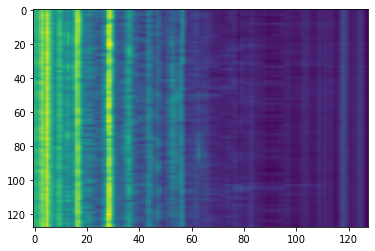

2020-11-09 02:09:32,208 - pytorch_modeler.py - INFO - Epoch 50/55:train_loss:8.638619, valid_AUC:0.753374, valid_pAUC:0.611812
100%|██████████| 832/832 [00:17<00:00, 48.94it/s]
2020-11-09 02:13:26,805 - pytorch_modeler.py - INFO - Epoch 51/55:train_loss:8.688516, valid_AUC:0.756111, valid_pAUC:0.624970
100%|██████████| 832/832 [00:17<00:00, 48.19it/s]
2020-11-09 02:17:30,284 - pytorch_modeler.py - INFO - Epoch 52/55:train_loss:8.524752, valid_AUC:0.755093, valid_pAUC:0.621010
100%|██████████| 832/832 [00:15<00:00, 53.68it/s]
2020-11-09 02:21:25,554 - pytorch_modeler.py - INFO - Epoch 53/55:train_loss:8.520053, valid_AUC:0.747720, valid_pAUC:0.582511
100%|██████████| 832/832 [00:15<00:00, 54.04it/s]
2020-11-09 02:25:17,606 - pytorch_modeler.py - INFO - Epoch 54/55:train_loss:8.540140, valid_AUC:0.748594, valid_pAUC:0.611263
100%|██████████| 832/832 [00:15<00:00, 54.03it/s]
2020-11-09 02:29:09,186 - pytorch_modeler.py - INFO - Epoch 55/55:train_loss:8.383695, valid_AUC:0.746534, valid_pA

elapsed time: 13284.869321108 [sec]


2020-11-09 02:29:09,888 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-09 02:29:09,889 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-09 02:29:09,891 - 00_train.py - INFO - TRAINING
  0%|          | 0/324 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:29<00:00, 41.82it/s]


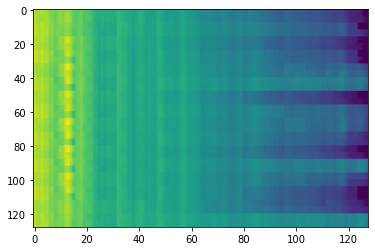

2020-11-09 02:33:16,802 - pytorch_modeler.py - INFO - Epoch 1/55:train_loss:924.618168, valid_AUC:0.249063, valid_pAUC:0.480061
100%|██████████| 1246/1246 [00:23<00:00, 54.06it/s]
2020-11-09 02:36:53,785 - pytorch_modeler.py - INFO - Epoch 2/55:train_loss:728.372382, valid_AUC:0.303895, valid_pAUC:0.481974
100%|██████████| 1246/1246 [00:23<00:00, 54.10it/s]
2020-11-09 02:40:30,858 - pytorch_modeler.py - INFO - Epoch 3/55:train_loss:573.723159, valid_AUC:0.296436, valid_pAUC:0.487869
100%|██████████| 1246/1246 [00:23<00:00, 53.25it/s]
2020-11-09 02:44:08,102 - pytorch_modeler.py - INFO - Epoch 4/55:train_loss:448.126222, valid_AUC:0.492236, valid_pAUC:0.497527
100%|██████████| 1246/1246 [00:23<00:00, 53.98it/s]
2020-11-09 02:47:45,056 - pytorch_modeler.py - INFO - Epoch 5/55:train_loss:344.743829, valid_AUC:0.345514, valid_pAUC:0.487915
100%|██████████| 1246/1246 [00:23<00:00, 53.82it/s]
2020-11-09 02:51:22,170 - pytorch_modeler.py - INFO - Epoch 6/55:train_loss:260.231897, valid_AUC:0.

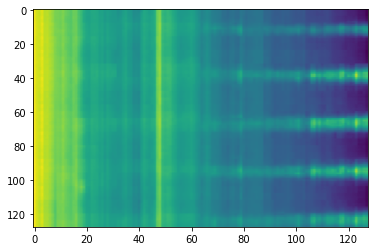

2020-11-09 03:05:50,130 - pytorch_modeler.py - INFO - Epoch 10/55:train_loss:66.959724, valid_AUC:0.739400, valid_pAUC:0.568822
100%|██████████| 1246/1246 [00:23<00:00, 53.96it/s]
2020-11-09 03:09:27,191 - pytorch_modeler.py - INFO - Epoch 11/55:train_loss:45.219678, valid_AUC:0.678354, valid_pAUC:0.535772
100%|██████████| 1246/1246 [00:23<00:00, 54.07it/s]
2020-11-09 03:13:04,116 - pytorch_modeler.py - INFO - Epoch 12/55:train_loss:30.613824, valid_AUC:0.818138, valid_pAUC:0.596211
100%|██████████| 1246/1246 [00:23<00:00, 53.93it/s]
2020-11-09 03:16:40,905 - pytorch_modeler.py - INFO - Epoch 13/55:train_loss:21.271882, valid_AUC:0.816930, valid_pAUC:0.596802
100%|██████████| 1246/1246 [00:22<00:00, 54.20it/s]
2020-11-09 03:20:17,775 - pytorch_modeler.py - INFO - Epoch 14/55:train_loss:15.968959, valid_AUC:0.830260, valid_pAUC:0.638500
100%|██████████| 1246/1246 [00:23<00:00, 53.95it/s]
2020-11-09 03:23:54,816 - pytorch_modeler.py - INFO - Epoch 15/55:train_loss:13.080286, valid_AUC:0.

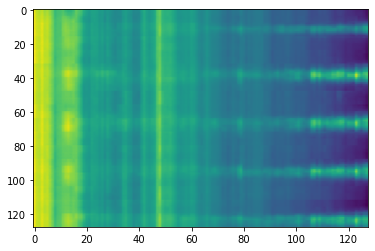

2020-11-09 03:41:59,533 - pytorch_modeler.py - INFO - Epoch 20/55:train_loss:10.783801, valid_AUC:0.854341, valid_pAUC:0.677103
100%|██████████| 1246/1246 [00:22<00:00, 54.25it/s]
2020-11-09 03:45:36,365 - pytorch_modeler.py - INFO - Epoch 21/55:train_loss:10.759094, valid_AUC:0.851392, valid_pAUC:0.664194
100%|██████████| 1246/1246 [00:23<00:00, 53.80it/s]
2020-11-09 03:49:13,259 - pytorch_modeler.py - INFO - Epoch 22/55:train_loss:10.669998, valid_AUC:0.852249, valid_pAUC:0.665609
100%|██████████| 1246/1246 [00:23<00:00, 54.13it/s]
2020-11-09 03:52:50,102 - pytorch_modeler.py - INFO - Epoch 23/55:train_loss:10.693551, valid_AUC:0.856135, valid_pAUC:0.682531
100%|██████████| 1246/1246 [00:23<00:00, 53.62it/s]
2020-11-09 03:56:27,167 - pytorch_modeler.py - INFO - Epoch 24/55:train_loss:10.646581, valid_AUC:0.858602, valid_pAUC:0.692469
100%|██████████| 1246/1246 [00:23<00:00, 53.09it/s]
2020-11-09 04:00:04,209 - pytorch_modeler.py - INFO - Epoch 25/55:train_loss:10.600322, valid_AUC:0.

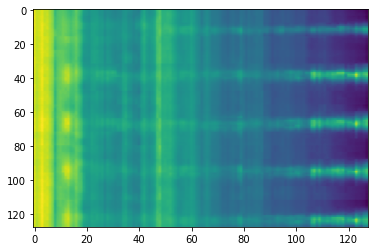

2020-11-09 04:18:08,704 - pytorch_modeler.py - INFO - Epoch 30/55:train_loss:10.422827, valid_AUC:0.859784, valid_pAUC:0.670228
100%|██████████| 1246/1246 [00:23<00:00, 53.80it/s]
2020-11-09 04:21:45,481 - pytorch_modeler.py - INFO - Epoch 31/55:train_loss:10.399354, valid_AUC:0.869743, valid_pAUC:0.710137
100%|██████████| 1246/1246 [00:23<00:00, 53.61it/s]
2020-11-09 04:25:22,471 - pytorch_modeler.py - INFO - Epoch 32/55:train_loss:10.418263, valid_AUC:0.869072, valid_pAUC:0.701272
100%|██████████| 1246/1246 [00:23<00:00, 53.54it/s]
2020-11-09 04:28:59,457 - pytorch_modeler.py - INFO - Epoch 33/55:train_loss:10.314110, valid_AUC:0.872190, valid_pAUC:0.709826
100%|██████████| 1246/1246 [00:23<00:00, 53.96it/s]
2020-11-09 04:32:36,080 - pytorch_modeler.py - INFO - Epoch 34/55:train_loss:10.285037, valid_AUC:0.870171, valid_pAUC:0.706980
100%|██████████| 1246/1246 [00:23<00:00, 53.94it/s]
2020-11-09 04:36:12,814 - pytorch_modeler.py - INFO - Epoch 35/55:train_loss:10.370589, valid_AUC:0.

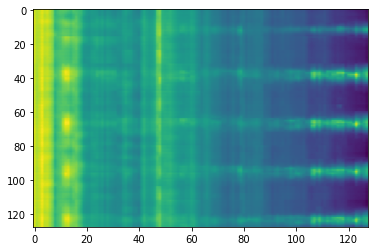

2020-11-09 04:54:16,468 - pytorch_modeler.py - INFO - Epoch 40/55:train_loss:10.200577, valid_AUC:0.877671, valid_pAUC:0.715083
100%|██████████| 1246/1246 [00:23<00:00, 53.86it/s]
2020-11-09 04:57:53,231 - pytorch_modeler.py - INFO - Epoch 41/55:train_loss:10.134504, valid_AUC:0.873685, valid_pAUC:0.713668
100%|██████████| 1246/1246 [00:23<00:00, 53.50it/s]
2020-11-09 05:01:30,267 - pytorch_modeler.py - INFO - Epoch 42/55:train_loss:10.127635, valid_AUC:0.868954, valid_pAUC:0.688457
100%|██████████| 1246/1246 [00:23<00:00, 53.61it/s]
2020-11-09 05:05:06,925 - pytorch_modeler.py - INFO - Epoch 43/55:train_loss:10.089087, valid_AUC:0.869066, valid_pAUC:0.688908
100%|██████████| 1246/1246 [00:23<00:00, 53.46it/s]
2020-11-09 05:08:43,888 - pytorch_modeler.py - INFO - Epoch 44/55:train_loss:10.013624, valid_AUC:0.872305, valid_pAUC:0.702345
100%|██████████| 1246/1246 [00:23<00:00, 53.83it/s]
2020-11-09 05:12:20,647 - pytorch_modeler.py - INFO - Epoch 45/55:train_loss:10.057305, valid_AUC:0.

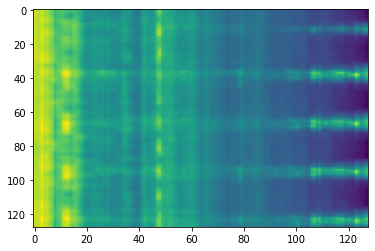

2020-11-09 05:30:24,321 - pytorch_modeler.py - INFO - Epoch 50/55:train_loss:9.963246, valid_AUC:0.879078, valid_pAUC:0.719625
100%|██████████| 1246/1246 [00:23<00:00, 53.66it/s]
2020-11-09 05:34:01,117 - pytorch_modeler.py - INFO - Epoch 51/55:train_loss:9.909818, valid_AUC:0.881726, valid_pAUC:0.718054
100%|██████████| 1246/1246 [00:23<00:00, 53.95it/s]
2020-11-09 05:37:37,544 - pytorch_modeler.py - INFO - Epoch 52/55:train_loss:9.912369, valid_AUC:0.882967, valid_pAUC:0.718863
100%|██████████| 1246/1246 [00:23<00:00, 53.97it/s]
2020-11-09 05:41:14,082 - pytorch_modeler.py - INFO - Epoch 53/55:train_loss:9.913866, valid_AUC:0.882861, valid_pAUC:0.737977
100%|██████████| 1246/1246 [00:22<00:00, 54.18it/s]
2020-11-09 05:44:50,608 - pytorch_modeler.py - INFO - Epoch 54/55:train_loss:9.878972, valid_AUC:0.877482, valid_pAUC:0.709422
100%|██████████| 1246/1246 [00:23<00:00, 53.72it/s]
2020-11-09 05:48:27,086 - pytorch_modeler.py - INFO - Epoch 55/55:train_loss:9.829855, valid_AUC:0.880916

elapsed time: 11957.344131231 [sec]


2020-11-09 05:48:27,773 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-09 05:48:27,774 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-09 05:48:27,776 - 00_train.py - INFO - TRAINING
  0%|          | 0/438 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [01:00<00:00, 40.00it/s]


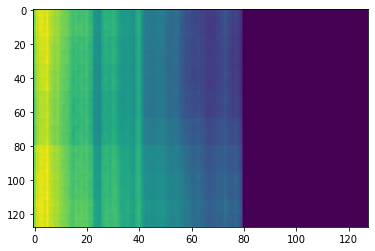

2020-11-09 05:54:27,821 - pytorch_modeler.py - INFO - Epoch 1/55:train_loss:732.549912, valid_AUC:0.420937, valid_pAUC:0.500321
100%|██████████| 2407/2407 [00:44<00:00, 53.91it/s]
2020-11-09 05:59:35,407 - pytorch_modeler.py - INFO - Epoch 2/55:train_loss:495.436803, valid_AUC:0.398708, valid_pAUC:0.499731
100%|██████████| 2407/2407 [00:45<00:00, 53.47it/s]
2020-11-09 06:04:43,349 - pytorch_modeler.py - INFO - Epoch 3/55:train_loss:328.107858, valid_AUC:0.487527, valid_pAUC:0.506261
100%|██████████| 2407/2407 [00:44<00:00, 53.78it/s]
2020-11-09 06:09:51,160 - pytorch_modeler.py - INFO - Epoch 4/55:train_loss:213.351779, valid_AUC:0.401840, valid_pAUC:0.502572
100%|██████████| 2407/2407 [00:44<00:00, 53.80it/s]
2020-11-09 06:14:58,961 - pytorch_modeler.py - INFO - Epoch 5/55:train_loss:134.375575, valid_AUC:0.410890, valid_pAUC:0.506444
100%|██████████| 2407/2407 [00:44<00:00, 53.72it/s]
2020-11-09 06:20:06,380 - pytorch_modeler.py - INFO - Epoch 6/55:train_loss:81.016940, valid_AUC:0.4

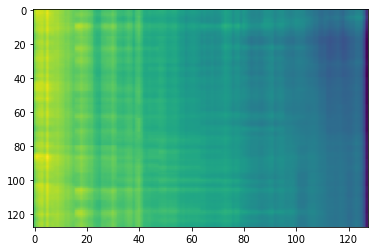

2020-11-09 06:40:36,153 - pytorch_modeler.py - INFO - Epoch 10/55:train_loss:12.532752, valid_AUC:0.797751, valid_pAUC:0.658985
100%|██████████| 2407/2407 [00:44<00:00, 53.93it/s]
2020-11-09 06:45:43,510 - pytorch_modeler.py - INFO - Epoch 11/55:train_loss:10.970361, valid_AUC:0.767892, valid_pAUC:0.638818
100%|██████████| 2407/2407 [00:44<00:00, 54.05it/s]
2020-11-09 06:50:50,359 - pytorch_modeler.py - INFO - Epoch 12/55:train_loss:10.471155, valid_AUC:0.756744, valid_pAUC:0.632341
100%|██████████| 2407/2407 [00:44<00:00, 53.82it/s]
2020-11-09 06:55:57,688 - pytorch_modeler.py - INFO - Epoch 13/55:train_loss:10.301365, valid_AUC:0.771528, valid_pAUC:0.640330
100%|██████████| 2407/2407 [00:44<00:00, 54.02it/s]
2020-11-09 07:01:04,828 - pytorch_modeler.py - INFO - Epoch 14/55:train_loss:10.151372, valid_AUC:0.793360, valid_pAUC:0.646049
100%|██████████| 2407/2407 [00:44<00:00, 53.81it/s]
2020-11-09 07:06:11,880 - pytorch_modeler.py - INFO - Epoch 15/55:train_loss:10.064628, valid_AUC:0.

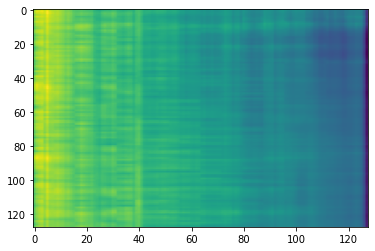

2020-11-09 07:31:48,262 - pytorch_modeler.py - INFO - Epoch 20/55:train_loss:9.520565, valid_AUC:0.783906, valid_pAUC:0.630843
100%|██████████| 2407/2407 [00:44<00:00, 54.06it/s]
2020-11-09 07:36:55,057 - pytorch_modeler.py - INFO - Epoch 21/55:train_loss:9.412098, valid_AUC:0.819381, valid_pAUC:0.666392
100%|██████████| 2407/2407 [00:44<00:00, 53.90it/s]
2020-11-09 07:42:02,208 - pytorch_modeler.py - INFO - Epoch 22/55:train_loss:9.328549, valid_AUC:0.814158, valid_pAUC:0.641670
100%|██████████| 2407/2407 [00:44<00:00, 53.97it/s]
2020-11-09 07:47:09,359 - pytorch_modeler.py - INFO - Epoch 23/55:train_loss:9.160661, valid_AUC:0.762007, valid_pAUC:0.626532
100%|██████████| 2407/2407 [00:44<00:00, 53.72it/s]
2020-11-09 07:52:16,321 - pytorch_modeler.py - INFO - Epoch 24/55:train_loss:8.985933, valid_AUC:0.744689, valid_pAUC:0.602374
100%|██████████| 2407/2407 [00:44<00:00, 53.84it/s]
2020-11-09 07:57:23,436 - pytorch_modeler.py - INFO - Epoch 25/55:train_loss:8.899520, valid_AUC:0.782119

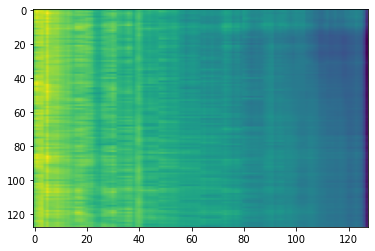

2020-11-09 08:22:59,448 - pytorch_modeler.py - INFO - Epoch 30/55:train_loss:8.485780, valid_AUC:0.758979, valid_pAUC:0.613618
100%|██████████| 2407/2407 [00:44<00:00, 53.75it/s]
2020-11-09 08:28:06,589 - pytorch_modeler.py - INFO - Epoch 31/55:train_loss:8.351499, valid_AUC:0.795852, valid_pAUC:0.611270
100%|██████████| 2407/2407 [00:44<00:00, 53.74it/s]
2020-11-09 08:33:13,787 - pytorch_modeler.py - INFO - Epoch 32/55:train_loss:8.275375, valid_AUC:0.761983, valid_pAUC:0.602161
100%|██████████| 2407/2407 [00:44<00:00, 53.73it/s]
2020-11-09 08:38:20,821 - pytorch_modeler.py - INFO - Epoch 33/55:train_loss:8.254044, valid_AUC:0.763378, valid_pAUC:0.592876
100%|██████████| 2407/2407 [00:44<00:00, 54.19it/s]
2020-11-09 08:43:27,577 - pytorch_modeler.py - INFO - Epoch 34/55:train_loss:8.275511, valid_AUC:0.781399, valid_pAUC:0.623020
100%|██████████| 2407/2407 [00:45<00:00, 53.42it/s]
2020-11-09 08:48:34,951 - pytorch_modeler.py - INFO - Epoch 35/55:train_loss:8.191755, valid_AUC:0.803845

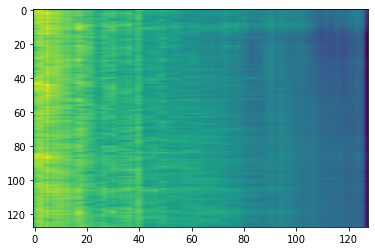

2020-11-09 09:14:09,983 - pytorch_modeler.py - INFO - Epoch 40/55:train_loss:7.907466, valid_AUC:0.782533, valid_pAUC:0.618725
100%|██████████| 2407/2407 [00:44<00:00, 53.64it/s]
2020-11-09 09:19:17,072 - pytorch_modeler.py - INFO - Epoch 41/55:train_loss:7.873121, valid_AUC:0.715290, valid_pAUC:0.595180
100%|██████████| 2407/2407 [00:44<00:00, 53.53it/s]
2020-11-09 09:24:24,051 - pytorch_modeler.py - INFO - Epoch 42/55:train_loss:7.781328, valid_AUC:0.771524, valid_pAUC:0.598099
100%|██████████| 2407/2407 [00:44<00:00, 53.56it/s]
2020-11-09 09:29:31,314 - pytorch_modeler.py - INFO - Epoch 43/55:train_loss:7.746356, valid_AUC:0.756015, valid_pAUC:0.596259
100%|██████████| 2407/2407 [00:44<00:00, 53.94it/s]
2020-11-09 09:34:38,191 - pytorch_modeler.py - INFO - Epoch 44/55:train_loss:7.708713, valid_AUC:0.795995, valid_pAUC:0.610411
100%|██████████| 2407/2407 [00:45<00:00, 53.25it/s]
2020-11-09 09:39:45,337 - pytorch_modeler.py - INFO - Epoch 45/55:train_loss:7.747288, valid_AUC:0.724755

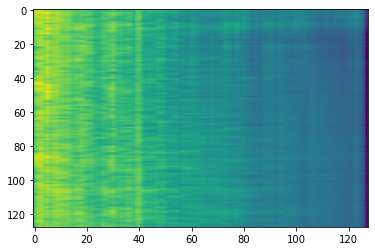

2020-11-09 10:05:19,715 - pytorch_modeler.py - INFO - Epoch 50/55:train_loss:7.455531, valid_AUC:0.769253, valid_pAUC:0.589098
100%|██████████| 2407/2407 [00:44<00:00, 53.77it/s]
2020-11-09 10:10:26,367 - pytorch_modeler.py - INFO - Epoch 51/55:train_loss:7.442104, valid_AUC:0.697295, valid_pAUC:0.548420
100%|██████████| 2407/2407 [00:44<00:00, 54.22it/s]
2020-11-09 10:15:32,984 - pytorch_modeler.py - INFO - Epoch 52/55:train_loss:7.407296, valid_AUC:0.590134, valid_pAUC:0.523740
100%|██████████| 2407/2407 [00:44<00:00, 54.00it/s]
2020-11-09 10:20:39,789 - pytorch_modeler.py - INFO - Epoch 53/55:train_loss:7.363667, valid_AUC:0.810871, valid_pAUC:0.615530
100%|██████████| 2407/2407 [00:44<00:00, 54.05it/s]
2020-11-09 10:25:46,164 - pytorch_modeler.py - INFO - Epoch 54/55:train_loss:7.353271, valid_AUC:0.690560, valid_pAUC:0.514705
100%|██████████| 2407/2407 [00:44<00:00, 53.67it/s]
2020-11-09 10:30:53,228 - pytorch_modeler.py - INFO - Epoch 55/55:train_loss:7.325084, valid_AUC:0.756254

elapsed time: 16945.617683649 [sec]


2020-11-09 10:30:53,914 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-09 10:30:53,915 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-09 10:30:53,917 - 00_train.py - INFO - TRAINING
  0%|          | 0/375 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [01:24<00:00, 41.06it/s]


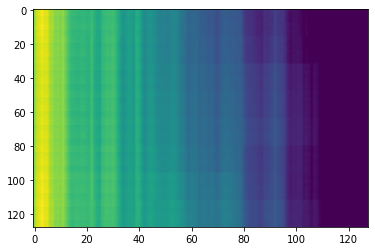

2020-11-09 10:36:58,659 - pytorch_modeler.py - INFO - Epoch 1/55:train_loss:437.937824, valid_AUC:0.467553, valid_pAUC:0.497040
100%|██████████| 3452/3452 [01:03<00:00, 54.06it/s]
2020-11-09 10:41:47,750 - pytorch_modeler.py - INFO - Epoch 2/55:train_loss:272.273072, valid_AUC:0.468932, valid_pAUC:0.497241
100%|██████████| 3452/3452 [01:04<00:00, 53.84it/s]
2020-11-09 10:46:36,944 - pytorch_modeler.py - INFO - Epoch 3/55:train_loss:165.042041, valid_AUC:0.471751, valid_pAUC:0.497256
100%|██████████| 3452/3452 [01:04<00:00, 53.91it/s]
2020-11-09 10:51:26,151 - pytorch_modeler.py - INFO - Epoch 4/55:train_loss:98.671243, valid_AUC:0.479652, valid_pAUC:0.500324
100%|██████████| 3452/3452 [01:04<00:00, 53.78it/s]
2020-11-09 10:56:15,474 - pytorch_modeler.py - INFO - Epoch 5/55:train_loss:61.127084, valid_AUC:0.493208, valid_pAUC:0.500880
100%|██████████| 3452/3452 [01:03<00:00, 53.96it/s]
2020-11-09 11:01:04,191 - pytorch_modeler.py - INFO - Epoch 6/55:train_loss:40.405261, valid_AUC:0.478

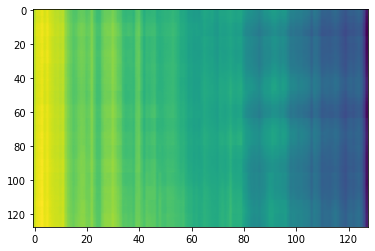

2020-11-09 11:20:19,790 - pytorch_modeler.py - INFO - Epoch 10/55:train_loss:14.827319, valid_AUC:0.583539, valid_pAUC:0.514130
100%|██████████| 3452/3452 [01:07<00:00, 51.01it/s]
2020-11-09 11:25:12,336 - pytorch_modeler.py - INFO - Epoch 11/55:train_loss:14.590721, valid_AUC:0.592056, valid_pAUC:0.507197
100%|██████████| 3452/3452 [01:07<00:00, 51.30it/s]
2020-11-09 11:30:06,626 - pytorch_modeler.py - INFO - Epoch 12/55:train_loss:14.396327, valid_AUC:0.591525, valid_pAUC:0.519672
100%|██████████| 3452/3452 [01:07<00:00, 51.11it/s]
2020-11-09 11:35:04,333 - pytorch_modeler.py - INFO - Epoch 13/55:train_loss:14.206246, valid_AUC:0.618786, valid_pAUC:0.516743
100%|██████████| 3452/3452 [01:06<00:00, 51.84it/s]
2020-11-09 11:39:56,908 - pytorch_modeler.py - INFO - Epoch 14/55:train_loss:14.025343, valid_AUC:0.601467, valid_pAUC:0.511304
100%|██████████| 3452/3452 [01:04<00:00, 53.38it/s]
2020-11-09 11:44:46,603 - pytorch_modeler.py - INFO - Epoch 15/55:train_loss:13.853669, valid_AUC:0.

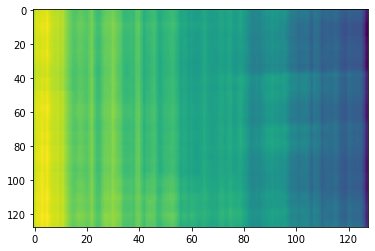

2020-11-09 12:08:56,877 - pytorch_modeler.py - INFO - Epoch 20/55:train_loss:13.412799, valid_AUC:0.624001, valid_pAUC:0.525175
100%|██████████| 3452/3452 [01:03<00:00, 53.97it/s]
2020-11-09 12:13:45,783 - pytorch_modeler.py - INFO - Epoch 21/55:train_loss:13.312459, valid_AUC:0.626121, valid_pAUC:0.524751
100%|██████████| 3452/3452 [01:04<00:00, 53.78it/s]
2020-11-09 12:18:34,578 - pytorch_modeler.py - INFO - Epoch 22/55:train_loss:13.262867, valid_AUC:0.645088, valid_pAUC:0.532291
100%|██████████| 3452/3452 [01:03<00:00, 54.27it/s]
2020-11-09 12:23:22,990 - pytorch_modeler.py - INFO - Epoch 23/55:train_loss:13.203691, valid_AUC:0.627684, valid_pAUC:0.533560
100%|██████████| 3452/3452 [01:04<00:00, 53.73it/s]
2020-11-09 12:28:12,166 - pytorch_modeler.py - INFO - Epoch 24/55:train_loss:13.470565, valid_AUC:0.638231, valid_pAUC:0.529831
100%|██████████| 3452/3452 [01:04<00:00, 53.51it/s]
2020-11-09 12:33:01,218 - pytorch_modeler.py - INFO - Epoch 25/55:train_loss:13.143961, valid_AUC:0.

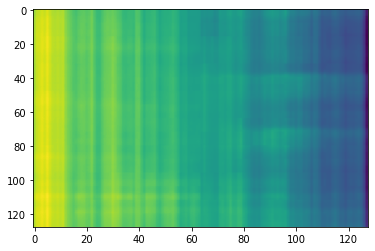

2020-11-09 12:57:05,182 - pytorch_modeler.py - INFO - Epoch 30/55:train_loss:12.738397, valid_AUC:0.650394, valid_pAUC:0.538179
100%|██████████| 3452/3452 [01:04<00:00, 53.59it/s]
2020-11-09 13:01:54,095 - pytorch_modeler.py - INFO - Epoch 31/55:train_loss:12.721336, valid_AUC:0.671774, valid_pAUC:0.543348
100%|██████████| 3452/3452 [01:04<00:00, 53.77it/s]
2020-11-09 13:06:43,037 - pytorch_modeler.py - INFO - Epoch 32/55:train_loss:12.689145, valid_AUC:0.641194, valid_pAUC:0.535949
100%|██████████| 3452/3452 [01:03<00:00, 53.94it/s]
2020-11-09 13:11:31,744 - pytorch_modeler.py - INFO - Epoch 33/55:train_loss:12.689512, valid_AUC:0.639824, valid_pAUC:0.538161
100%|██████████| 3452/3452 [01:04<00:00, 53.46it/s]
2020-11-09 13:16:20,865 - pytorch_modeler.py - INFO - Epoch 34/55:train_loss:12.670375, valid_AUC:0.652611, valid_pAUC:0.548794
100%|██████████| 3452/3452 [01:04<00:00, 53.72it/s]
2020-11-09 13:21:09,845 - pytorch_modeler.py - INFO - Epoch 35/55:train_loss:12.677455, valid_AUC:0.

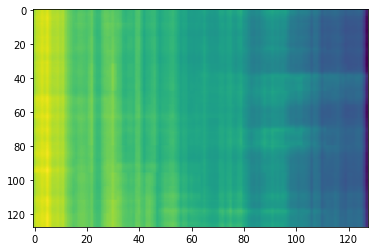

2020-11-09 13:45:14,301 - pytorch_modeler.py - INFO - Epoch 40/55:train_loss:12.357371, valid_AUC:0.663421, valid_pAUC:0.555247
100%|██████████| 3452/3452 [01:04<00:00, 53.47it/s]
2020-11-09 13:50:03,487 - pytorch_modeler.py - INFO - Epoch 41/55:train_loss:12.374200, valid_AUC:0.662828, valid_pAUC:0.551657
100%|██████████| 3452/3452 [01:04<00:00, 53.76it/s]
2020-11-09 13:54:52,342 - pytorch_modeler.py - INFO - Epoch 42/55:train_loss:12.399542, valid_AUC:0.645130, valid_pAUC:0.550031
100%|██████████| 3452/3452 [01:04<00:00, 53.64it/s]
2020-11-09 13:59:41,140 - pytorch_modeler.py - INFO - Epoch 43/55:train_loss:12.347078, valid_AUC:0.677268, valid_pAUC:0.556927
100%|██████████| 3452/3452 [01:04<00:00, 53.59it/s]
2020-11-09 14:04:30,239 - pytorch_modeler.py - INFO - Epoch 44/55:train_loss:12.349189, valid_AUC:0.662990, valid_pAUC:0.553205
100%|██████████| 3452/3452 [01:04<00:00, 53.64it/s]
2020-11-09 14:09:19,231 - pytorch_modeler.py - INFO - Epoch 45/55:train_loss:12.290981, valid_AUC:0.

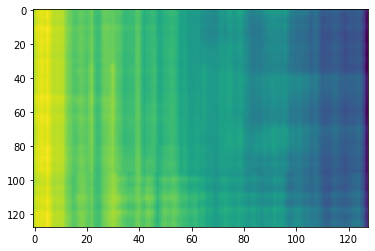

2020-11-09 14:33:22,968 - pytorch_modeler.py - INFO - Epoch 50/55:train_loss:12.213974, valid_AUC:0.670487, valid_pAUC:0.555464
100%|██████████| 3452/3452 [01:04<00:00, 53.57it/s]
2020-11-09 14:38:11,964 - pytorch_modeler.py - INFO - Epoch 51/55:train_loss:12.286672, valid_AUC:0.629953, valid_pAUC:0.525216
100%|██████████| 3452/3452 [01:04<00:00, 53.71it/s]
2020-11-09 14:43:00,559 - pytorch_modeler.py - INFO - Epoch 52/55:train_loss:12.213582, valid_AUC:0.668261, valid_pAUC:0.552163
100%|██████████| 3452/3452 [01:03<00:00, 53.98it/s]
2020-11-09 14:47:49,095 - pytorch_modeler.py - INFO - Epoch 53/55:train_loss:12.135035, valid_AUC:0.649405, valid_pAUC:0.552546
100%|██████████| 3452/3452 [01:04<00:00, 53.75it/s]
2020-11-09 14:52:37,788 - pytorch_modeler.py - INFO - Epoch 54/55:train_loss:12.150522, valid_AUC:0.671168, valid_pAUC:0.560069
100%|██████████| 3452/3452 [01:04<00:00, 53.93it/s]
2020-11-09 14:57:26,114 - pytorch_modeler.py - INFO - Epoch 55/55:train_loss:12.252890, valid_AUC:0.

elapsed time: 15992.377786160 [sec]


2020-11-09 14:57:26,865 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-09 14:57:26,866 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-09 14:57:26,868 - 00_train.py - INFO - TRAINING
  0%|          | 0/364 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 855/855 [00:20<00:00, 41.46it/s]


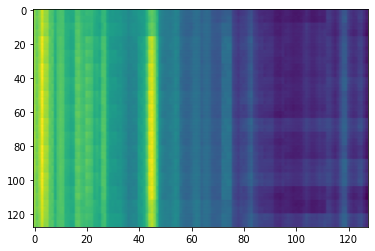

2020-11-09 15:02:19,135 - pytorch_modeler.py - INFO - Epoch 1/55:train_loss:905.963699, valid_AUC:0.482830, valid_pAUC:0.502892
100%|██████████| 855/855 [00:16<00:00, 53.30it/s]
2020-11-09 15:06:13,729 - pytorch_modeler.py - INFO - Epoch 2/55:train_loss:691.903150, valid_AUC:0.480805, valid_pAUC:0.498496
100%|██████████| 855/855 [00:15<00:00, 53.80it/s]
2020-11-09 15:10:07,984 - pytorch_modeler.py - INFO - Epoch 3/55:train_loss:526.634050, valid_AUC:0.471637, valid_pAUC:0.508271
100%|██████████| 855/855 [00:16<00:00, 53.05it/s]
2020-11-09 15:14:02,598 - pytorch_modeler.py - INFO - Epoch 4/55:train_loss:396.444504, valid_AUC:0.448121, valid_pAUC:0.491267
100%|██████████| 855/855 [00:16<00:00, 53.21it/s]
2020-11-09 15:17:57,029 - pytorch_modeler.py - INFO - Epoch 5/55:train_loss:291.670902, valid_AUC:0.475198, valid_pAUC:0.493956
100%|██████████| 855/855 [00:15<00:00, 54.11it/s]
2020-11-09 15:21:51,284 - pytorch_modeler.py - INFO - Epoch 6/55:train_loss:209.000960, valid_AUC:0.489481, va

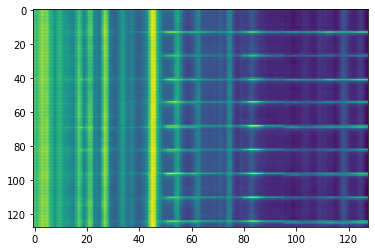

2020-11-09 15:37:28,346 - pytorch_modeler.py - INFO - Epoch 10/55:train_loss:41.027621, valid_AUC:0.550231, valid_pAUC:0.495084
100%|██████████| 855/855 [00:15<00:00, 53.79it/s]
2020-11-09 15:41:22,575 - pytorch_modeler.py - INFO - Epoch 11/55:train_loss:26.442060, valid_AUC:0.574934, valid_pAUC:0.502834
100%|██████████| 855/855 [00:15<00:00, 53.92it/s]
2020-11-09 15:45:16,702 - pytorch_modeler.py - INFO - Epoch 12/55:train_loss:17.946631, valid_AUC:0.572720, valid_pAUC:0.498496
100%|██████████| 855/855 [00:16<00:00, 52.98it/s]
2020-11-09 15:49:11,133 - pytorch_modeler.py - INFO - Epoch 13/55:train_loss:13.482898, valid_AUC:0.556571, valid_pAUC:0.503586
100%|██████████| 855/855 [00:15<00:00, 53.70it/s]
2020-11-09 15:53:05,379 - pytorch_modeler.py - INFO - Epoch 14/55:train_loss:11.586227, valid_AUC:0.564868, valid_pAUC:0.502776
100%|██████████| 855/855 [00:16<00:00, 53.43it/s]
2020-11-09 15:56:59,623 - pytorch_modeler.py - INFO - Epoch 15/55:train_loss:10.781991, valid_AUC:0.588731, va

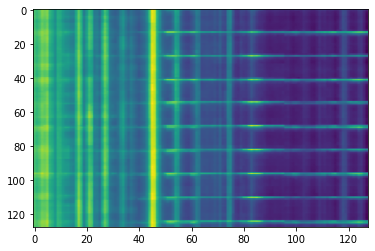

2020-11-09 16:16:31,048 - pytorch_modeler.py - INFO - Epoch 20/55:train_loss:10.286646, valid_AUC:0.608978, valid_pAUC:0.507432
100%|██████████| 855/855 [00:15<00:00, 53.88it/s]
2020-11-09 16:20:25,146 - pytorch_modeler.py - INFO - Epoch 21/55:train_loss:10.215200, valid_AUC:0.624643, valid_pAUC:0.506998
100%|██████████| 855/855 [00:15<00:00, 53.90it/s]
2020-11-09 16:24:19,250 - pytorch_modeler.py - INFO - Epoch 22/55:train_loss:10.196261, valid_AUC:0.635220, valid_pAUC:0.504800
100%|██████████| 855/855 [00:15<00:00, 53.48it/s]
2020-11-09 16:28:13,400 - pytorch_modeler.py - INFO - Epoch 23/55:train_loss:10.158096, valid_AUC:0.623841, valid_pAUC:0.506044
100%|██████████| 855/855 [00:15<00:00, 53.51it/s]
2020-11-09 16:32:07,645 - pytorch_modeler.py - INFO - Epoch 24/55:train_loss:10.027566, valid_AUC:0.633871, valid_pAUC:0.505957
100%|██████████| 855/855 [00:16<00:00, 52.96it/s]
2020-11-09 16:36:01,989 - pytorch_modeler.py - INFO - Epoch 25/55:train_loss:10.021276, valid_AUC:0.621379, va

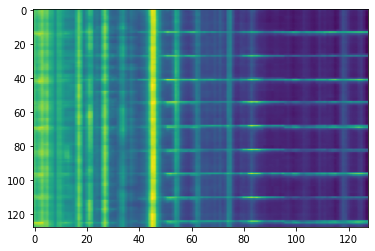

2020-11-09 16:55:33,007 - pytorch_modeler.py - INFO - Epoch 30/55:train_loss:9.938755, valid_AUC:0.645088, valid_pAUC:0.509109
100%|██████████| 855/855 [00:15<00:00, 53.71it/s]
2020-11-09 16:59:27,084 - pytorch_modeler.py - INFO - Epoch 31/55:train_loss:9.955787, valid_AUC:0.640390, valid_pAUC:0.505899
100%|██████████| 855/855 [00:15<00:00, 53.80it/s]
2020-11-09 17:03:21,090 - pytorch_modeler.py - INFO - Epoch 32/55:train_loss:10.002247, valid_AUC:0.630423, valid_pAUC:0.507663
100%|██████████| 855/855 [00:15<00:00, 53.45it/s]
2020-11-09 17:07:15,175 - pytorch_modeler.py - INFO - Epoch 33/55:train_loss:9.915976, valid_AUC:0.639346, valid_pAUC:0.508704
100%|██████████| 855/855 [00:15<00:00, 53.68it/s]
2020-11-09 17:11:09,219 - pytorch_modeler.py - INFO - Epoch 34/55:train_loss:9.900320, valid_AUC:0.637269, valid_pAUC:0.510758
100%|██████████| 855/855 [00:15<00:00, 53.55it/s]
2020-11-09 17:15:03,237 - pytorch_modeler.py - INFO - Epoch 35/55:train_loss:9.787664, valid_AUC:0.647027, valid_p

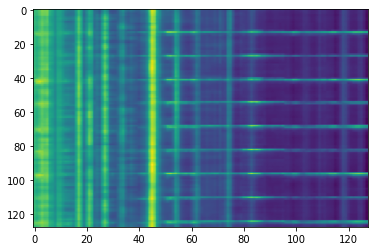

2020-11-09 17:34:32,932 - pytorch_modeler.py - INFO - Epoch 40/55:train_loss:9.674093, valid_AUC:0.661225, valid_pAUC:0.513968
100%|██████████| 855/855 [00:15<00:00, 54.02it/s]
2020-11-09 17:38:26,731 - pytorch_modeler.py - INFO - Epoch 41/55:train_loss:9.581304, valid_AUC:0.654615, valid_pAUC:0.509109
100%|██████████| 855/855 [00:15<00:00, 53.75it/s]
2020-11-09 17:42:20,604 - pytorch_modeler.py - INFO - Epoch 42/55:train_loss:9.565695, valid_AUC:0.649214, valid_pAUC:0.511423
100%|██████████| 855/855 [00:15<00:00, 53.93it/s]
2020-11-09 17:46:14,463 - pytorch_modeler.py - INFO - Epoch 43/55:train_loss:9.666041, valid_AUC:0.652126, valid_pAUC:0.514488
100%|██████████| 855/855 [00:15<00:00, 53.69it/s]
2020-11-09 17:50:08,304 - pytorch_modeler.py - INFO - Epoch 44/55:train_loss:9.549074, valid_AUC:0.652731, valid_pAUC:0.512955
100%|██████████| 855/855 [00:16<00:00, 53.29it/s]
2020-11-09 17:54:02,319 - pytorch_modeler.py - INFO - Epoch 45/55:train_loss:9.511299, valid_AUC:0.657549, valid_pA

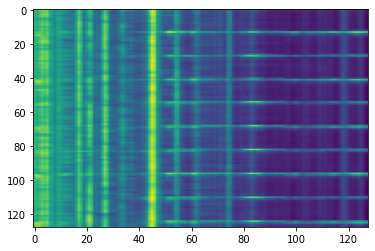

2020-11-09 18:13:32,343 - pytorch_modeler.py - INFO - Epoch 50/55:train_loss:9.292372, valid_AUC:0.652929, valid_pAUC:0.510237
100%|██████████| 855/855 [00:15<00:00, 53.46it/s]
2020-11-09 18:17:26,341 - pytorch_modeler.py - INFO - Epoch 51/55:train_loss:9.323321, valid_AUC:0.656709, valid_pAUC:0.510758
100%|██████████| 855/855 [00:15<00:00, 53.89it/s]
2020-11-09 18:21:20,210 - pytorch_modeler.py - INFO - Epoch 52/55:train_loss:9.255358, valid_AUC:0.656203, valid_pAUC:0.510873
100%|██████████| 855/855 [00:15<00:00, 53.89it/s]
2020-11-09 18:25:14,086 - pytorch_modeler.py - INFO - Epoch 53/55:train_loss:9.209813, valid_AUC:0.664533, valid_pAUC:0.509225
100%|██████████| 855/855 [00:16<00:00, 53.42it/s]
2020-11-09 18:29:08,055 - pytorch_modeler.py - INFO - Epoch 54/55:train_loss:9.260147, valid_AUC:0.657984, valid_pAUC:0.512927
100%|██████████| 855/855 [00:16<00:00, 53.26it/s]
2020-11-09 18:33:02,031 - pytorch_modeler.py - INFO - Epoch 55/55:train_loss:9.194474, valid_AUC:0.651505, valid_pA

elapsed time: 12935.348055840 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)